⚠️ No se detectó GPU. Usando CPU.

📂 Clases detectadas: {'esophagitis': 0, 'polyps': 1, 'ulcerative-colitis': 2}

🚀 Entrenando MobileNetV2 congelado...

🔧 Fine-tuning MobileNetV2...


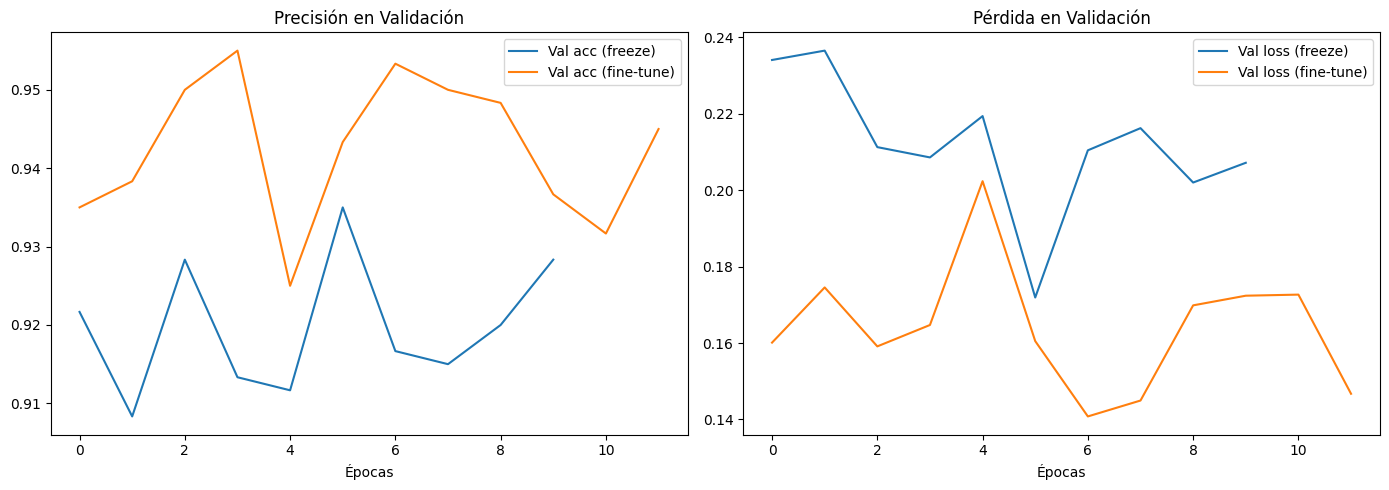


✅ Precisión final del mejor modelo: 94.00%

📊 Matriz de confusión:
 [[195   1   4]
 [  5 180  15]
 [  0  11 189]]

📝 Reporte de clasificación:
                     precision    recall  f1-score   support

       esophagitis     0.9750    0.9750    0.9750       200
            polyps     0.9375    0.9000    0.9184       200
ulcerative-colitis     0.9087    0.9450    0.9265       200

          accuracy                         0.9400       600
         macro avg     0.9404    0.9400    0.9399       600
      weighted avg     0.9404    0.9400    0.9399       600


📌 Métricas detalladas por clase:

Clase: esophagitis
TP: 195, FP: 5, FN: 5, TN: 395
Precisión: 0.9750, Recall: 0.9750, Specificity: 0.9875
Accuracy: 0.9833, F1-score: 0.9750

Clase: polyps
TP: 180, FP: 12, FN: 20, TN: 388
Precisión: 0.9375, Recall: 0.9000, Specificity: 0.9700
Accuracy: 0.9467, F1-score: 0.9184

Clase: ulcerative-colitis
TP: 189, FP: 19, FN: 11, TN: 381
Precisión: 0.9087, Recall: 0.9450, Specificity: 0.9525
Accu

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, applications, callbacks
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ Detectar GPU (usará CPU si no hay GPU)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("✅ GPU activada:", gpus[0].name)
    except RuntimeError as e:
        print("❌ Error al configurar GPU:", e)
else:
    print("⚠️ No se detectó GPU. Usando CPU.")

# 2️⃣ Preprocesamiento personalizado
def crop_center(image, target_size=(224, 224)):
    width, height = image.size
    new_width, new_height = target_size
    left = (width - new_width)//2
    top = (height - new_height)//2
    return image.crop((left, top, left + new_width, top + new_height))

def remove_bottom_left_corner(image, crop_pixels=80):
    np_img = np.array(image)
    h, w = np_img.shape[:2]
    np_img[h - crop_pixels:, :crop_pixels] = 0
    return Image.fromarray(np_img)

def enhance_contrast(img):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2YCrCb)
    img_cv[:, :, 0] = cv2.equalizeHist(img_cv[:, :, 0])
    img_eq = cv2.cvtColor(img_cv, cv2.COLOR_YCrCb2RGB)
    return Image.fromarray(img_eq)

def custom_preprocess(img):
    img = Image.fromarray(np.uint8(img))
    img = crop_center(img)
    img = remove_bottom_left_corner(img)
    img = enhance_contrast(img)
    return np.array(img) / 255.0

# 3️⃣ Preparar generadores de datos
data_dir = './kvasir-dataset-v2'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Muy importante para que predicción y etiquetas coincidan
)

print("\n📂 Clases detectadas:", train_generator.class_indices)

# 4️⃣ Crear modelo MobileNetV2
def create_model():
    base_model = applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, base_model

model, base_model = create_model()

# 5️⃣ Callbacks
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint(
        filepath='best_mobilenet.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
]

# 6️⃣ Entrenamiento fase 1 (base congelada)
print("\n🚀 Entrenando MobileNetV2 congelado...")
history1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1
)

# 7️⃣ Fine-tuning (descongelar últimas 30 capas)
print("\n🔧 Fine-tuning MobileNetV2...")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1
)

# 8️⃣ Visualizar métricas
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history1.history['val_accuracy'], label='Val acc (freeze)')
plt.plot(history2.history['val_accuracy'], label='Val acc (fine-tune)')
plt.title('Precisión en Validación')
plt.xlabel('Épocas')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history1.history['val_loss'], label='Val loss (freeze)')
plt.plot(history2.history['val_loss'], label='Val loss (fine-tune)')
plt.title('Pérdida en Validación')
plt.xlabel('Épocas')
plt.legend()

plt.tight_layout()
plt.show()

# 9️⃣ Evaluación final
model.load_weights('best_mobilenet.weights.h5')
val_loss, val_acc = model.evaluate(val_generator)
print(f"\n✅ Precisión final del mejor modelo: {val_acc:.2%}")

# 1️⃣0️⃣ Métricas avanzadas (confusion matrix y report)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(train_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
print("\n📊 Matriz de confusión:\n", cm)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\n📝 Reporte de clasificación:\n", report)

# Función para métricas TP, FP, FN, TN y derivados por clase
def compute_metrics_multiclass(cm, class_names):
    total = np.sum(cm)
    print("\n📌 Métricas detalladas por clase:\n")
    for i, class_name in enumerate(class_names):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        TN = total - (TP + FP + FN)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (TP + TN) / total

        print(f"Clase: {class_name}")
        print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
        print(f"Precisión: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")
        print(f"Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}\n")

compute_metrics_multiclass(cm, class_names)


In [1]:
import os

data_dir = './kvasir-dataset-v2'
class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            fname for fname in os.listdir(class_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        class_counts[class_name] = count

print("🖼️ Número de imágenes por clase:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


🖼️ Número de imágenes por clase:
esophagitis: 1000
polyps: 1000
ulcerative-colitis: 1000
